# 3D Pix2Pix Results Visualization

Load and visualize inference results from NPZ files generated by test_save_npz.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path

print("📦 Libraries imported successfully")

📦 Libraries imported successfully


## 🔍 Load NPZ Results

**Note:** CT data is now automatically denormalized to Hounsfield Units in the test_save_npz.py script!

In [2]:
# Set the path to your NPZ results directory
# Update this path to match your results location
results_dir = "/home/sawall/scratch/results/hn_mr_to_ct_bs4/test_latest_npz"

# Find all NPZ files
npz_files = glob.glob(os.path.join(results_dir, "*.npz"))
npz_files.sort()

print(f"📁 Results directory: {results_dir}")
print(f"📊 Found {len(npz_files)} NPZ files:")
for i, file in enumerate(npz_files):
    print(f"   {i}: {os.path.basename(file)}")

print(f"\n💡 Note: NPZ files from test_save_npz.py contain CT data in Hounsfield Units!")

📁 Results directory: /home/sawall/scratch/results/hn_mr_to_ct_bs4/test_latest_npz
📊 Found 4 NPZ files:
   0: 1HNA001_mr_all_channels_synthetic_ct.npz
   1: 1HNA004_mr_all_channels_synthetic_ct.npz
   2: 1HNA006_mr_all_channels_synthetic_ct.npz
   3: 1HNA008_mr_all_channels_synthetic_ct.npz

💡 Note: NPZ files from test_save_npz.py contain CT data in Hounsfield Units!


In [3]:
# Select which file to visualize (change the index)
file_index = 0  # Change this to view different files

if len(npz_files) == 0:
    print("❌ No NPZ files found! Check your results directory path.")
else:
    selected_file = npz_files[file_index]
    print(f"🎯 Loading file: {os.path.basename(selected_file)}")
    
    # Load the NPZ file
    data = np.load(selected_file)
    
    print(f"\n📋 Available keys in NPZ file:")
    for key in data.keys():
        print(f"   {key}: {data[key].shape}")
    
    # Extract the data and handle 4D shapes (squeeze batch dimension if present)
    real_A = data['real_A']  # Input MR
    fake_B = data['fake_B']  # Generated synthetic CT (in HU)
    real_B = data['real_B'] if 'real_B' in data.keys() else None  # Ground truth CT (in HU)
    
    # Handle 4D shapes by squeezing the batch dimension
    if len(real_A.shape) == 4 and real_A.shape[0] == 1:
        print("🔧 Detected 4D data with batch dimension, squeezing to 3D...")
        real_A = np.squeeze(real_A, axis=0)
        fake_B = np.squeeze(fake_B, axis=0)
        if real_B is not None:
            real_B = np.squeeze(real_B, axis=0)
    
    print(f"\n📊 Data shapes and ranges (after processing):")
    print(f"   Input MR (real_A): {real_A.shape}")
    print(f"     └─ Range: [{real_A.min():.3f}, {real_A.max():.3f}] (original units)")
    
    print(f"   Generated CT (fake_B): {fake_B.shape}")
    print(f"     └─ Range: [{fake_B.min():.1f}, {fake_B.max():.1f}] HU")
    
    if real_B is not None:
        print(f"   Ground Truth CT (real_B): {real_B.shape}")
        print(f"     └─ Range: [{real_B.min():.1f}, {real_B.max():.1f}] HU")
    else:
        print(f"   Ground Truth CT (real_B): Not available")
    
    # Display typical CT values for reference
    print(f"\n🏥 Typical CT Values (HU):")
    print(f"   Air: -1000, Fat: -100 to -50, Water: 0, Muscle: 10-40")
    print(f"   Soft tissue: 20-70, Bone: 700-3000, Metal: >3000")

🎯 Loading file: 1HNA001_mr_all_channels_synthetic_ct.npz

📋 Available keys in NPZ file:
   fake_B: (32, 128, 128)
   real_A: (32, 128, 128)
   sample_name: ()

📊 Data shapes and ranges (after processing):
   Input MR (real_A): (32, 128, 128)
     └─ Range: [-4.649, 4.377] (original units)
   Generated CT (fake_B): (32, 128, 128)
     └─ Range: [-1024.0, 1196.6] HU
   Ground Truth CT (real_B): Not available

🏥 Typical CT Values (HU):
   Air: -1000, Fat: -100 to -50, Water: 0, Muscle: 10-40
   Soft tissue: 20-70, Bone: 700-3000, Metal: >3000


## 📊 Visualize Results

In [4]:
def visualize_3d_data(data, title, slice_idx=None, cmap='gray', units="", ct_windowing=None):
    """Visualize 3D medical data by showing three orthogonal slices"""
    
    # Handle different data shapes
    if len(data.shape) == 4:
        if data.shape[0] == 1:
            print(f"⚠️  Warning: 4D data detected with batch size 1. Auto-squeezing to 3D...")
            data = np.squeeze(data, axis=0)
            print(f"✅ Shape after squeezing: {data.shape}")
        else:
            print(f"❌ Error: 4D data with batch size {data.shape[0]} > 1. Cannot visualize.")
            print(f"   Current shape: {data.shape}")
            print(f"   Expected: (D, H, W) or (1, D, H, W)")
            return None
    
    if len(data.shape) == 3:
        D, H, W = data.shape
        print(f"✅ 3D data shape: {data.shape} (D={D}, H={H}, W={W})")
    else:
        print(f"❌ Error: Unexpected shape {data.shape}")
        print(f"   Expected: 3D shape (D, H, W)")
        return None
    
    # Default to middle slices if not specified
    if slice_idx is None:
        slice_idx = {
            'axial': D // 2,
            'coronal': H // 2,
            'sagittal': W // 2
        }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Set CT windowing for better visualization
    if ct_windowing is not None and units == "HU":
        vmin, vmax = ct_windowing
    else:
        vmin, vmax = data.min(), data.max()
    
    # Axial slice (top view)
    im1 = axes[0].imshow(data[slice_idx['axial'], :, :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(f'{title}\nAxial (slice {slice_idx["axial"]}/{D})')
    axes[0].axis('off')
    
    # Coronal slice (front view)
    im2 = axes[1].imshow(data[:, slice_idx['coronal'], :], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Coronal (slice {slice_idx["coronal"]}/{H})')
    axes[1].axis('off')
    
    # Sagittal slice (side view)
    im3 = axes[2].imshow(data[:, :, slice_idx['sagittal']], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[2].set_title(f'Sagittal (slice {slice_idx["sagittal"]}/{W})')
    axes[2].axis('off')
    
    # Add colorbar with units
    if units:
        cbar = plt.colorbar(im1, ax=axes, fraction=0.046, pad=0.04)
        cbar.set_label(f'Intensity ({units})', rotation=270, labelpad=15)
        
        # Show windowing info for CT data
        if ct_windowing is not None:
            plt.figtext(0.02, 0.02, f'CT Window: [{vmin:.0f}, {vmax:.0f}] HU', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return slice_idx

print("✅ Enhanced visualization function ready (with 4D shape handling and CT windowing support)")

✅ Enhanced visualization function ready (with 4D shape handling and CT windowing support)


🧠 Input MR Data (real_A):
✅ 3D data shape: (32, 128, 128) (D=32, H=128, W=128)


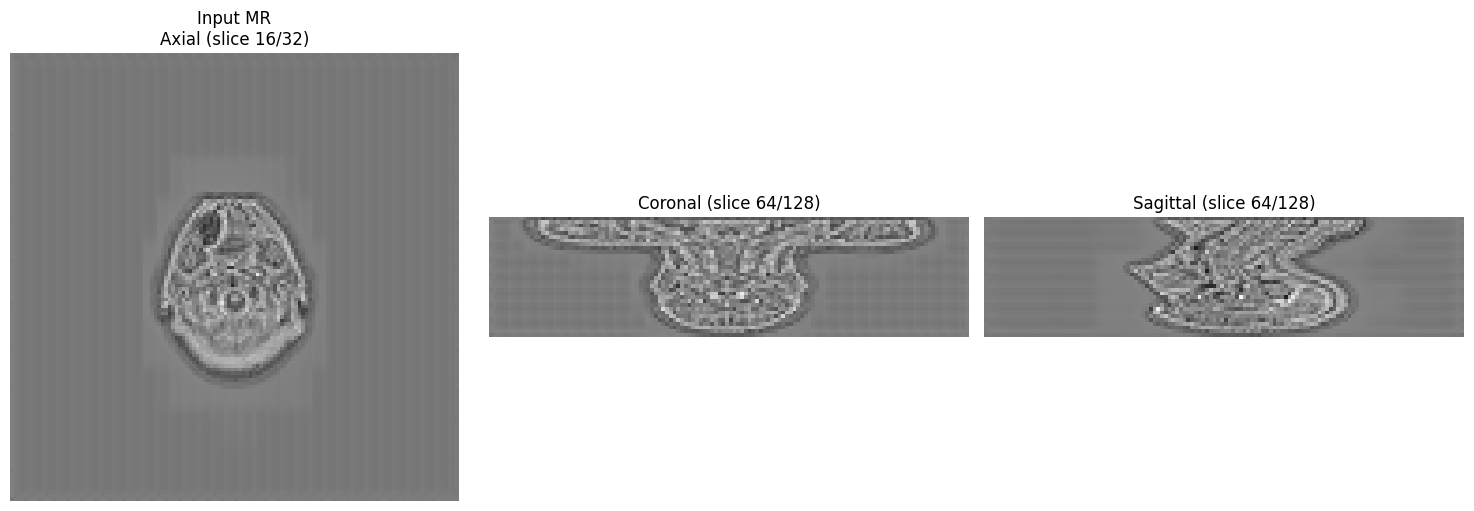

In [5]:
# Visualize Input MR (real_A)
if 'real_A' in locals():
    print("🧠 Input MR Data (real_A):")
    slice_idx = visualize_3d_data(real_A, "Input MR", cmap='gray')
else:
    print("❌ No data loaded. Run the previous cell first.")

🦴 Generated Synthetic CT (fake_B):
✅ 3D data shape: (32, 128, 128) (D=32, H=128, W=128)


/sctmp/sawall/ipykernel_2602165/527216166.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


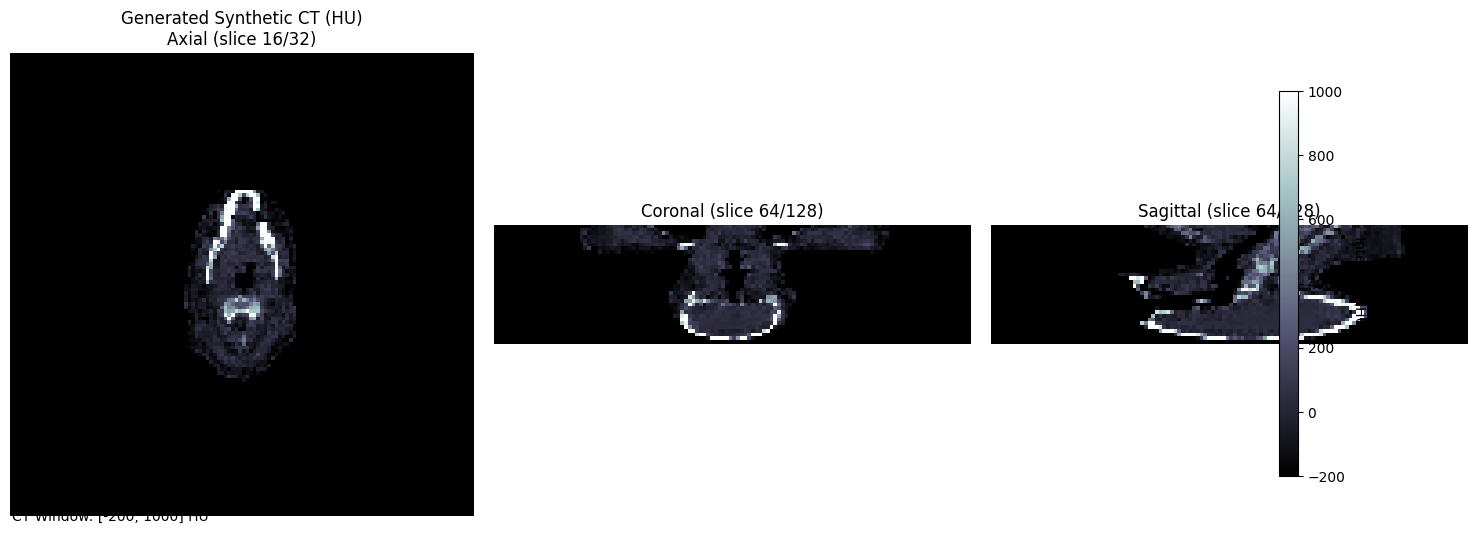

In [6]:
# Visualize Generated Synthetic CT (fake_B)
if 'fake_B' in locals():
    print("🦴 Generated Synthetic CT (fake_B):")
    # Use CT windowing for better visualization
    ct_window = (-200, 1000)  # Soft tissue to bone window
    visualize_3d_data(fake_B, "Generated Synthetic CT (HU)", 
                     slice_idx, cmap='bone', units="HU", ct_windowing=ct_window)
else:
    print("❌ No data loaded. Run the previous cell first.")

In [7]:
# Visualize Ground Truth CT (real_B) if available
if 'real_B' in locals() and real_B is not None:
    print("🎯 Ground Truth CT (real_B):")
    # Use CT windowing for better visualization
    ct_window = (-200, 1000)  # Soft tissue to bone window
    visualize_3d_data(real_B, "Ground Truth CT (HU)", 
                     slice_idx, cmap='bone', units="HU", ct_windowing=ct_window)
else:
    print("ℹ️ Ground truth CT not available in this file")

ℹ️ Ground truth CT not available in this file


## 🔍 Side-by-Side Comparison

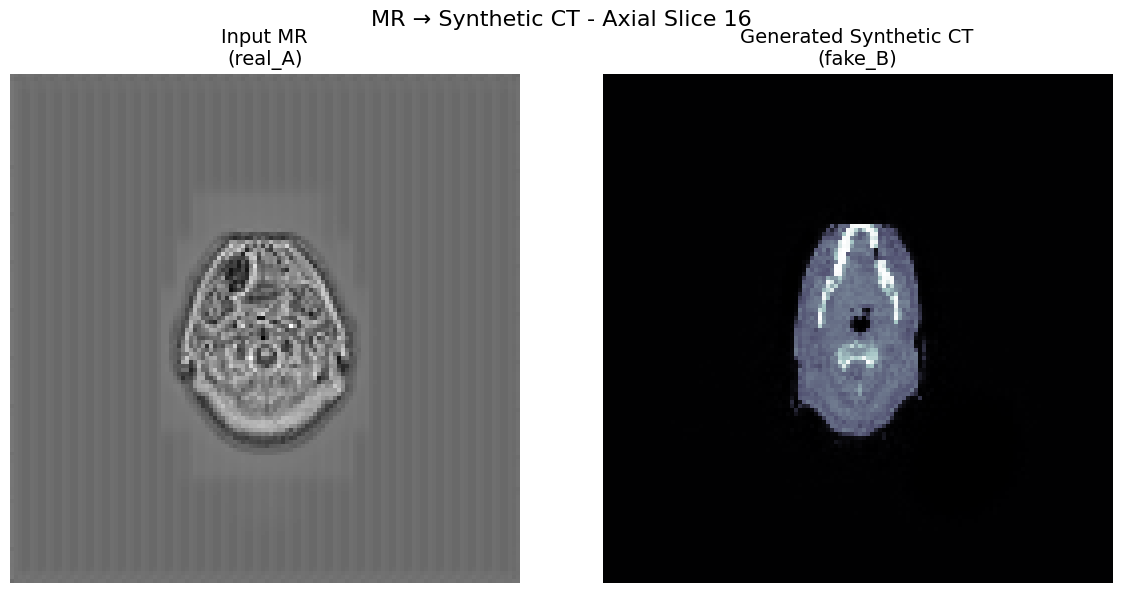


📈 Summary Statistics:
   Input MR (real_A): min=-4.649, max=4.377, mean=-0.265
   Generated CT (fake_B): min=-1024.000, max=1196.644, mean=-858.162


In [8]:
# Side-by-side comparison of all three (or two if no ground truth)
if 'real_A' in locals() and 'fake_B' in locals():
    
    # Use the same slice index for all comparisons
    axial_slice = slice_idx['axial']
    
    if real_B is not None:
        # Show all three: Input MR, Generated CT, Ground Truth CT
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        axes[0].imshow(real_A[axial_slice, :, :], cmap='gray')
        axes[0].set_title('Input MR\n(real_A)', fontsize=14)
        axes[0].axis('off')
        
        axes[1].imshow(fake_B[axial_slice, :, :], cmap='bone')
        axes[1].set_title('Generated Synthetic CT\n(fake_B)', fontsize=14)
        axes[1].axis('off')
        
        axes[2].imshow(real_B[axial_slice, :, :], cmap='bone')
        axes[2].set_title('Ground Truth CT\n(real_B)', fontsize=14)
        axes[2].axis('off')
        
        plt.suptitle(f'Comparison - Axial Slice {axial_slice}', fontsize=16)
        
    else:
        # Show only Input MR and Generated CT
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(real_A[axial_slice, :, :], cmap='gray')
        axes[0].set_title('Input MR\n(real_A)', fontsize=14)
        axes[0].axis('off')
        
        axes[1].imshow(fake_B[axial_slice, :, :], cmap='bone')
        axes[1].set_title('Generated Synthetic CT\n(fake_B)', fontsize=14)
        axes[1].axis('off')
        
        plt.suptitle(f'MR → Synthetic CT - Axial Slice {axial_slice}', fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Summary Statistics:")
    print(f"   Input MR (real_A): min={real_A.min():.3f}, max={real_A.max():.3f}, mean={real_A.mean():.3f}")
    print(f"   Generated CT (fake_B): min={fake_B.min():.3f}, max={fake_B.max():.3f}, mean={fake_B.mean():.3f}")
    if real_B is not None:
        print(f"   Ground Truth CT (real_B): min={real_B.min():.3f}, max={real_B.max():.3f}, mean={real_B.mean():.3f}")
else:
    print("❌ No data loaded. Run the loading cell first.")

## 💾 Export for Upscaling

In [9]:
# Save the synthetic CT for upscaling (now in proper HU units!)
if 'fake_B' in locals():
    
    # Extract model name from the results directory path
    # e.g., from "/path/to/results/1200_range_128/test_latest_npz" -> "1200_range_128"
    results_path = Path(results_dir)
    model_name = results_path.parent.name  # Get the model directory name
    
    # Create organized output directory structure: results/{model_name}/for_upscaling/
    model_results_dir = results_path.parent  # e.g., "/path/to/results/1200_range_128"
    output_dir = model_results_dir / "for_upscaling"
    output_dir.mkdir(exist_ok=True)
    
    # Get the base filename
    base_name = os.path.splitext(os.path.basename(selected_file))[0]
    
    # Save synthetic CT as NPZ for upscaling with model name
    output_filename = f"{base_name}_{model_name}_synthetic_ct.npz"
    output_file = output_dir / output_filename
    np.savez_compressed(output_file, synthetic_ct=fake_B)
    
    print(f"💾 Saved synthetic CT for upscaling:")
    print(f"   Model: {model_name}")
    print(f"   Directory: {output_dir}")
    print(f"   File: {output_filename}")
    print(f"   Full path: {output_file}")
    print(f"   Shape: {fake_B.shape}")
    print(f"   Data type: {fake_B.dtype}")
    print(f"   Value range: [{fake_B.min():.1f}, {fake_B.max():.1f}] HU")
    print(f"   Size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")
    
    print(f"\n📁 Organized Directory Structure:")
    print(f"   results/{model_name}/")
    print(f"   ├── test_XXX_npz/          (NPZ inference results)")
    print(f"   ├── for_upscaling/         (Files ready for upscaling) ← NEW FILE HERE")
    print(f"   └── upscaled_results/      (Final upscaled outputs)")
    
    print(f"\n🚀 Ready for upscaling! Synthetic CT from model '{model_name}' is now in organized structure.")
    print(f"   The Upscaling_Pipeline.ipynb will automatically detect this file!")
    print(f"   Load with: data = np.load('{output_file}'); ct = data['synthetic_ct']")
else:
    print("❌ No synthetic CT data available. Load data first.")

💾 Saved synthetic CT for upscaling:
   Model: hn_mr_to_ct_bs4
   Directory: /home/sawall/scratch/results/hn_mr_to_ct_bs4/for_upscaling
   File: 1HNA001_mr_all_channels_synthetic_ct_hn_mr_to_ct_bs4_synthetic_ct.npz
   Full path: /home/sawall/scratch/results/hn_mr_to_ct_bs4/for_upscaling/1HNA001_mr_all_channels_synthetic_ct_hn_mr_to_ct_bs4_synthetic_ct.npz
   Shape: (32, 128, 128)
   Data type: float32
   Value range: [-1024.0, 1196.6] HU
   Size: 1.45 MB

📁 Organized Directory Structure:
   results/hn_mr_to_ct_bs4/
   ├── test_XXX_npz/          (NPZ inference results)
   ├── for_upscaling/         (Files ready for upscaling) ← NEW FILE HERE
   └── upscaled_results/      (Final upscaled outputs)

🚀 Ready for upscaling! Synthetic CT from model 'hn_mr_to_ct_bs4' is now in organized structure.
   The Upscaling_Pipeline.ipynb will automatically detect this file!
   Load with: data = np.load('/home/sawall/scratch/results/hn_mr_to_ct_bs4/for_upscaling/1HNA001_mr_all_channels_synthetic_ct_hn_mr